# Active Noise Cancelling with Fast ICA and DWT Denoising

In [35]:
import os
import soundfile as sf
import numpy as np

inp_folder = 'audio_samples'
outp_folder = 'mixed_signals'
ica_folder = 'ica_samples'

# Load Audio Files

In [36]:
file_names = ['speech.wav', 'street.wav', 'music.wav', 'white_noise.wav']

audio_speech, sr_speech = sf.read(os.path.join(inp_folder, file_names[0]))
audio_street, sr_street = sf.read(os.path.join(inp_folder, file_names[1]))
audio_music, sr_music = sf.read(os.path.join(inp_folder, file_names[2]))
audio_wnoise, sr_wnoise = sf.read(os.path.join(inp_folder, file_names[3]))

print("Array Type is: {}".format(audio_music.dtype))
audio_wnoise = audio_wnoise / 5
audio_files = [audio_speech, audio_street, audio_music, audio_wnoise]
sample_rates = [sr_speech, sr_street, sr_music, sr_wnoise]
max_length = len(audio_files[0])

for name, sr, audio in zip(file_names, sample_rates, audio_files):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, sr, len(audio), len(audio)/sr))

Array Type is: float64
File: speech.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: street.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: music.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: white_noise.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec


In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

np.random.seed(10)

# True Signals

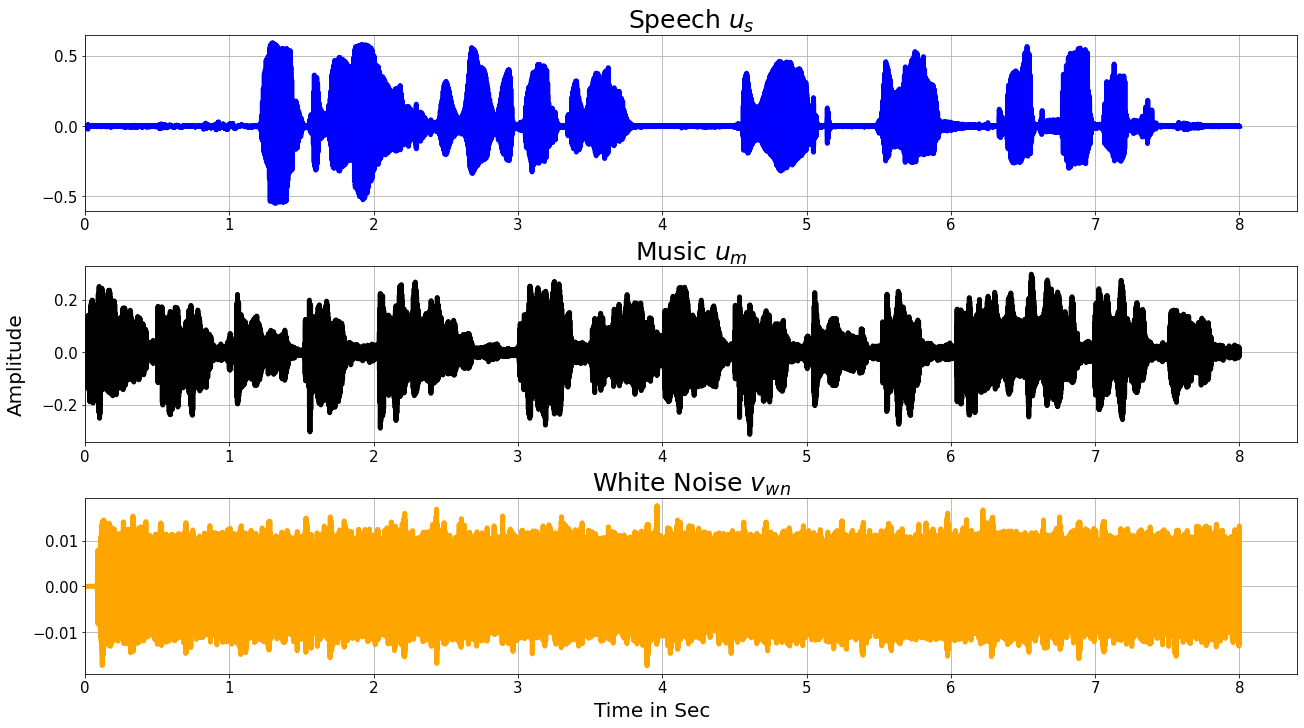

In [38]:
fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=False, constrained_layout = True)
audio_names = ['Speech $u_s$', 'Music $u_m$', 'White Noise $v_{wn}$']
colors = ['blue', 'black', 'orange']
for ii, (audio, name, sr, color) in enumerate(zip([audio_speech, audio_music, audio_wnoise], audio_names, sample_rates, colors)):
    x_axis = np.arange(0, len(audio)) / sr
    axs[ii].plot(x_axis, audio, lw=5, color=color)
    axs[ii].set_title(name, fontsize=25)

fig.supylabel('Amplitude', fontsize=20)
fig.supxlabel('Time in Sec', fontsize=20)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Simulate two Microphones

In [40]:
# Mix :                Music +                 Speech
d_sn_m_s_1 = 0.6 * audio_files[2] + 0.4 * audio_files[0] + audio_wnoise
d_sn_m_s_2 =  0.3 * audio_files[2] + 0.7 * audio_files[0] + audio_wnoise

true_signal = np.c_[audio_files[0], audio_files[2]]

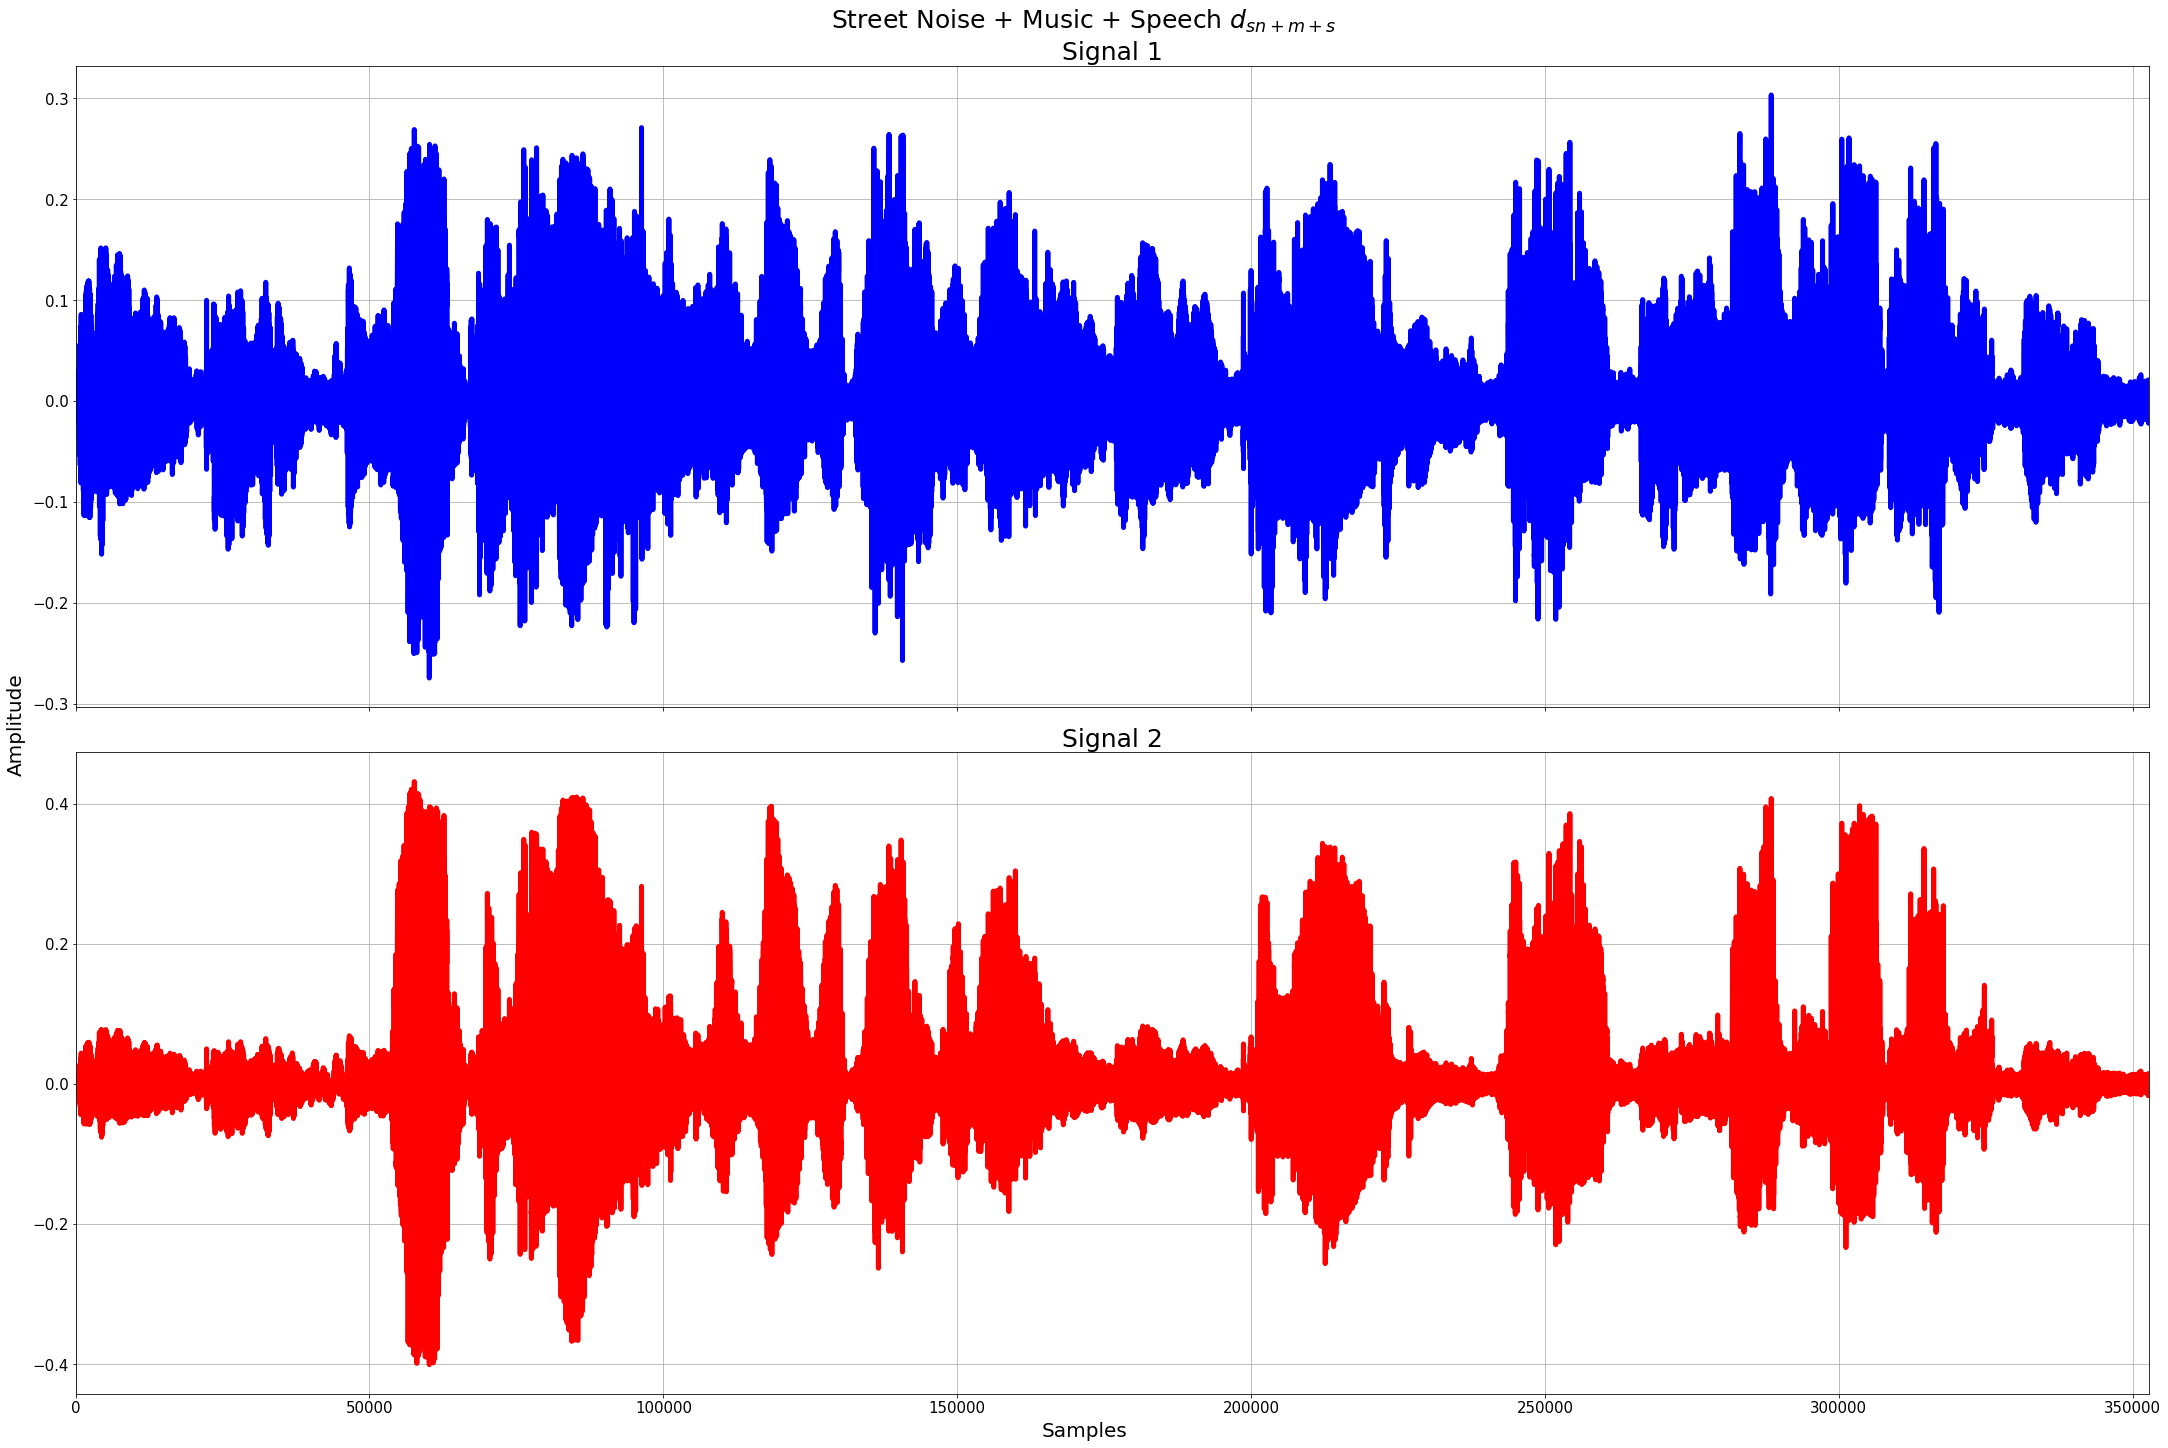

In [42]:
fig, axs = plt.subplots(2, 1, figsize=[30, 20], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)
fig.supxlabel('Samples', fontsize=20)
fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)

axs[0].plot(d_sn_m_s_1, lw=5, color='blue')
axs[0].set_title('Signal 1', fontsize=25)
axs[1].plot(d_sn_m_s_2, lw=5, color='red')
axs[1].set_title('Signal 2', fontsize=25)


for ax in axs: 
    ax.set_xlim(0, max_length)
    ax.tick_params(labelsize=15)
    ax.grid()

# Separate Mixed Signals (Fast ICA)

In [43]:
observation = np.c_[d_sn_m_s_1, d_sn_m_s_2]

observation /= observation.std(axis=0)

In [44]:
ica = FastICA()
ica_recovered = ica.fit_transform(observation) 
print(ica_recovered.shape)

(352800, 2)


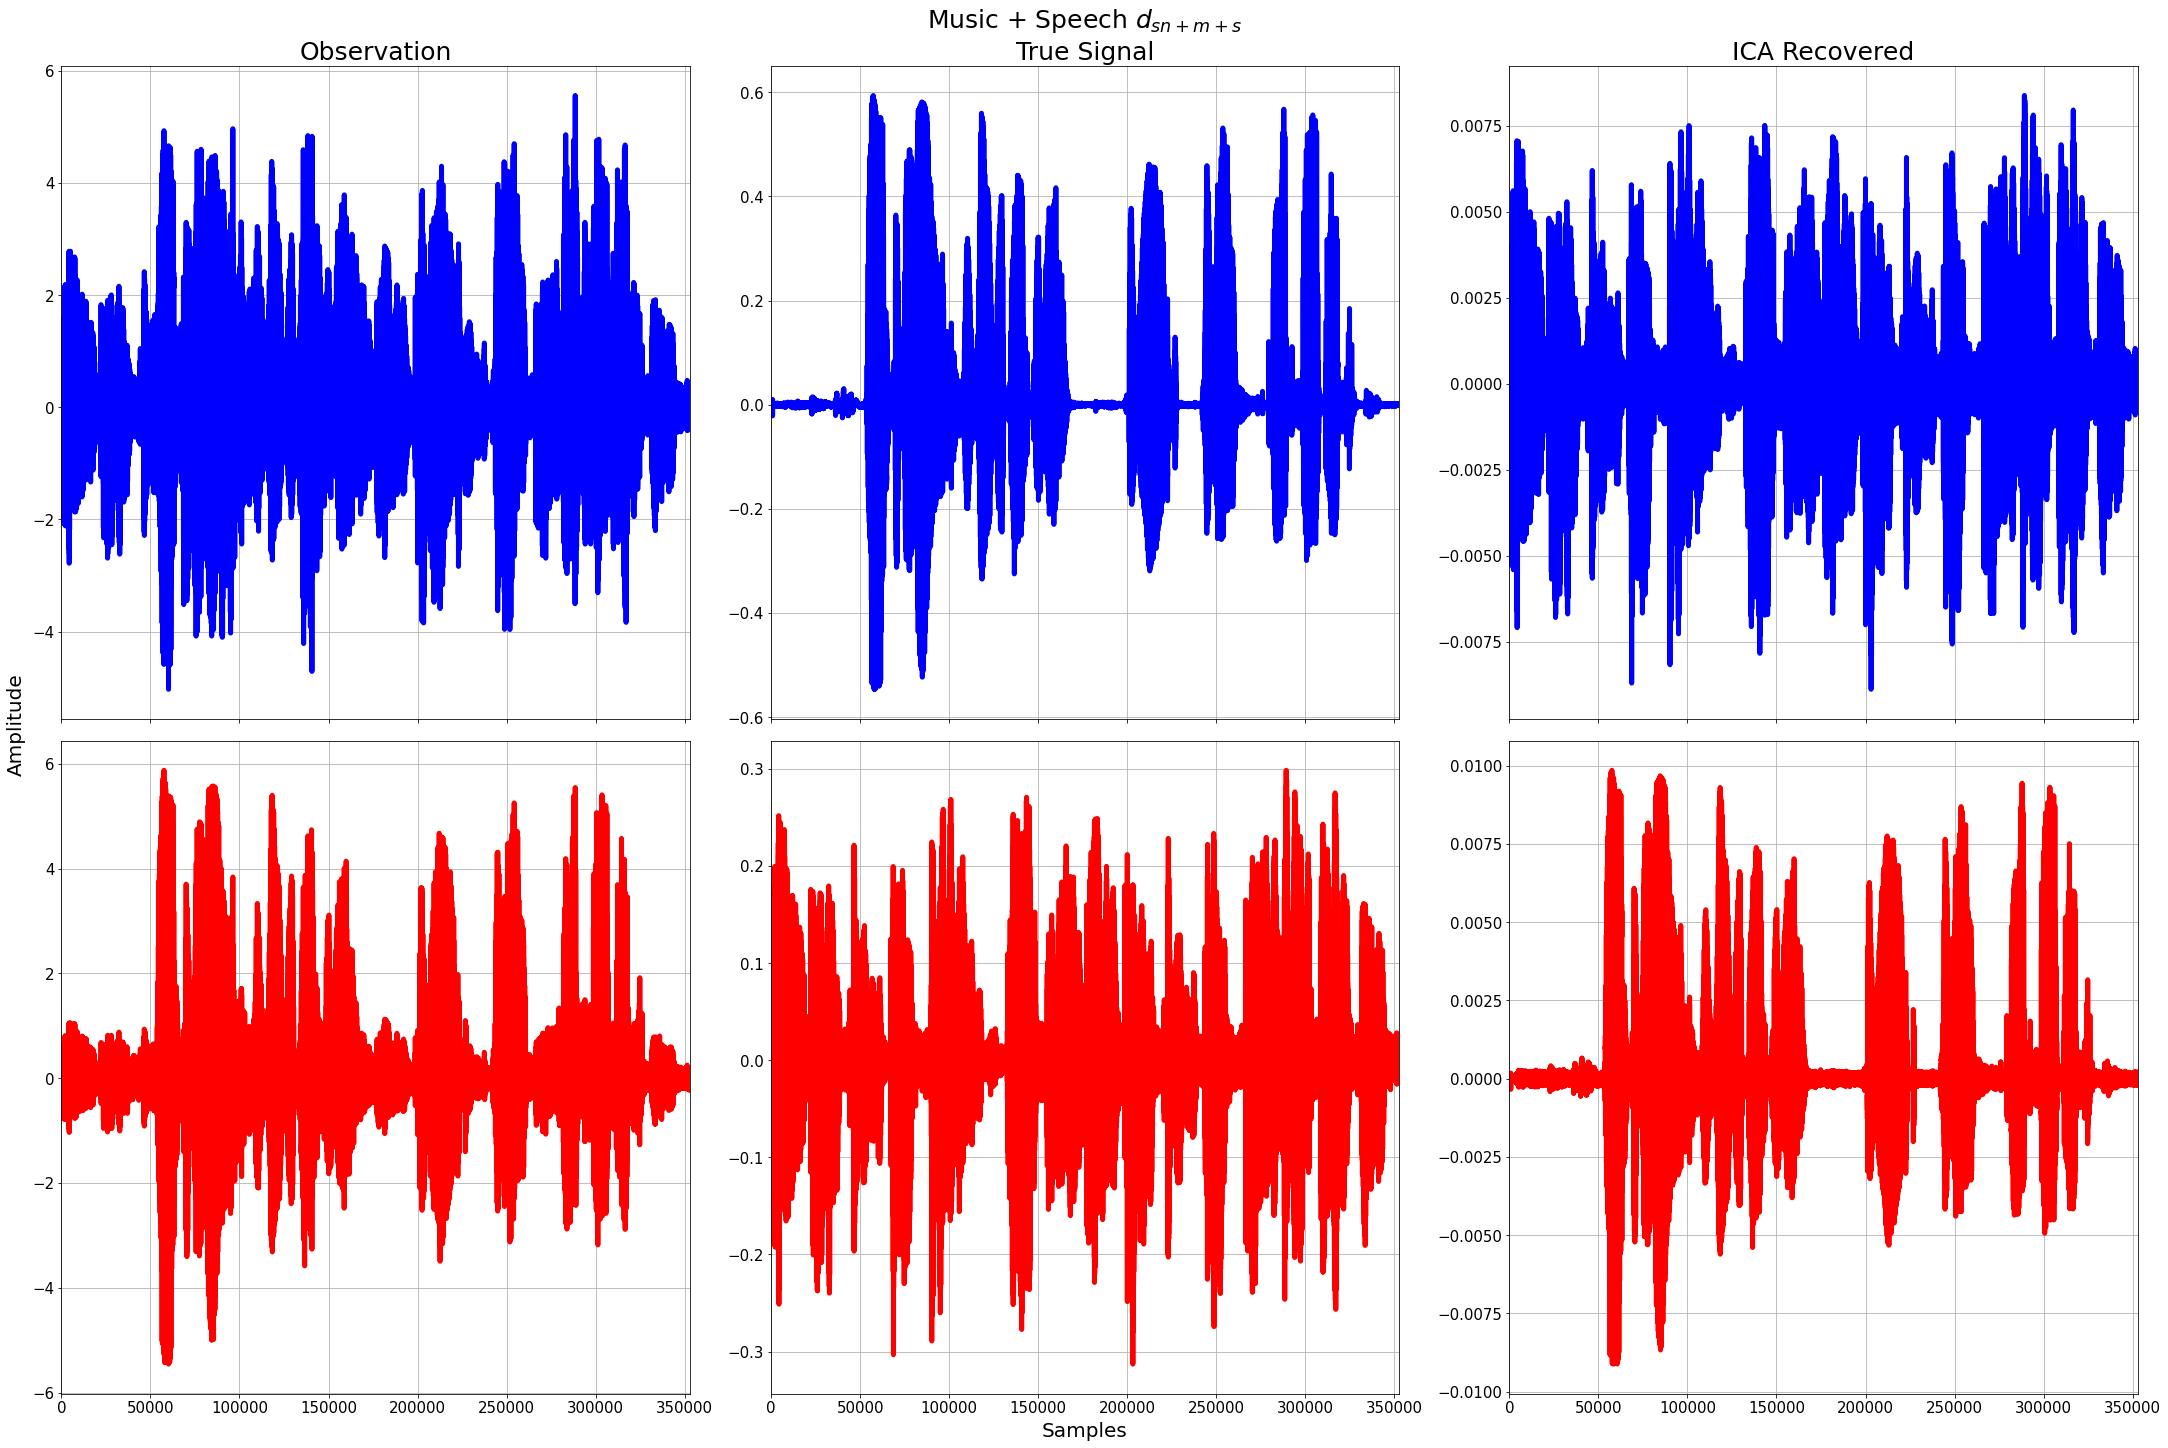

In [45]:
simple_plot = False
if simple_plot:
    fig, axs = plt.subplots(2, 1, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)
    fig.suptitle('Street Noise + Music + Speech $d_{sn+m+s}$', fontsize=25)
    
    axs[0].plot(ica_recovered[:, 0], lw=5, color='blue')
    axs[0].set_title('ICA Recovered', fontsize=25)
    axs[1].plot(ica_recovered[:, 1], lw=5, color='red')
    # axs[2].plot(ica_recovered[:, 2], lw=5, color='black')

    for ax in axs: 
        ax.set_xlim(0, max_length)
        ax.tick_params(labelsize=15)
        ax.grid()
else:
    ica_lst = [observation, true_signal, ica_recovered]
    ica_name = ['Observation', 'True Signal', 'ICA Recovered']
    fig, axs = plt.subplots(2, 3, figsize=[30, 20], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)
    fig.supxlabel('Samples', fontsize=20)
    fig.suptitle('Music + Speech $d_{sn+m+s}$', fontsize=25)

    for ii, (data, name) in enumerate(zip(ica_lst, ica_name)):
        axs[0][ii].plot(data[:, 0], lw=5, color='blue')
        axs[0][ii].set_title(name, fontsize=25)
        axs[1][ii].plot(data[:, 1], lw=5, color='red')
        # axs[2][ii].plot(data[:, 2], lw=5, color='black')

    for row in axs: 
        for ax in row: 
            ax.set_xlim(0, max_length)
            ax.tick_params(labelsize=15)
            ax.grid()

In [46]:
import pywt

In [47]:
wavelet = 'db3'
mode = 'sym'

# Sqtwolog Criterion

In [48]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d), axis)

In [49]:
def sqtwolog_criterion(coeffs): 
    # Sqtwolog Criterion
    coeff_thres = []
    for coeff in coeffs:
        sigma = (1/0.6745) * madev(coeffs[-1])
        threshold = sigma * np.sqrt(2 * np.log(max_length))
        coeff_thres.append(pywt.threshold(coeff, value=threshold, mode='garrote'))#hard soft
    return coeff_thres

# Singal Denoising (DWT)

In [50]:
def denoise(signal, wavelet, mode, plot_wavelets=False):
    coeffs = pywt.wavedec(signal, wavelet, mode=mode)
    cA = coeffs[0]
    cD = coeffs[1:]
    if plot_wavelets:
        fig, axs = plt.subplots(len(coeffs)+1, 1, figsize=[18, 30], sharex=True, constrained_layout = True)
        fig.supylabel('Amplitude', fontsize=20)

        axs[0].plot(ica_recovered[:, 0], lw=5)
        axs[0].set_title('Mixed Data', fontsize=25)

        for ii, coeff in enumerate(coeffs):
            axs[ii+1].plot(coeff, lw=5)
            axs[ii+1].set_title('c'+ str(ii), fontsize=25)

        axs[len(coeffs)].set_xlabel('Samples', fontsize=20)

        for ax in axs:
            ax.set_xlim(0)
            ax.tick_params(labelsize=15)
            ax.grid()

    cD_thres = sqtwolog_criterion(cD)       

    coeff_denoised = [cA]
    for ii in cD_thres:
        coeff_denoised.append(ii)

    return pywt.waverec(coeff_denoised , wavelet, mode=mode)



# Denoised Music

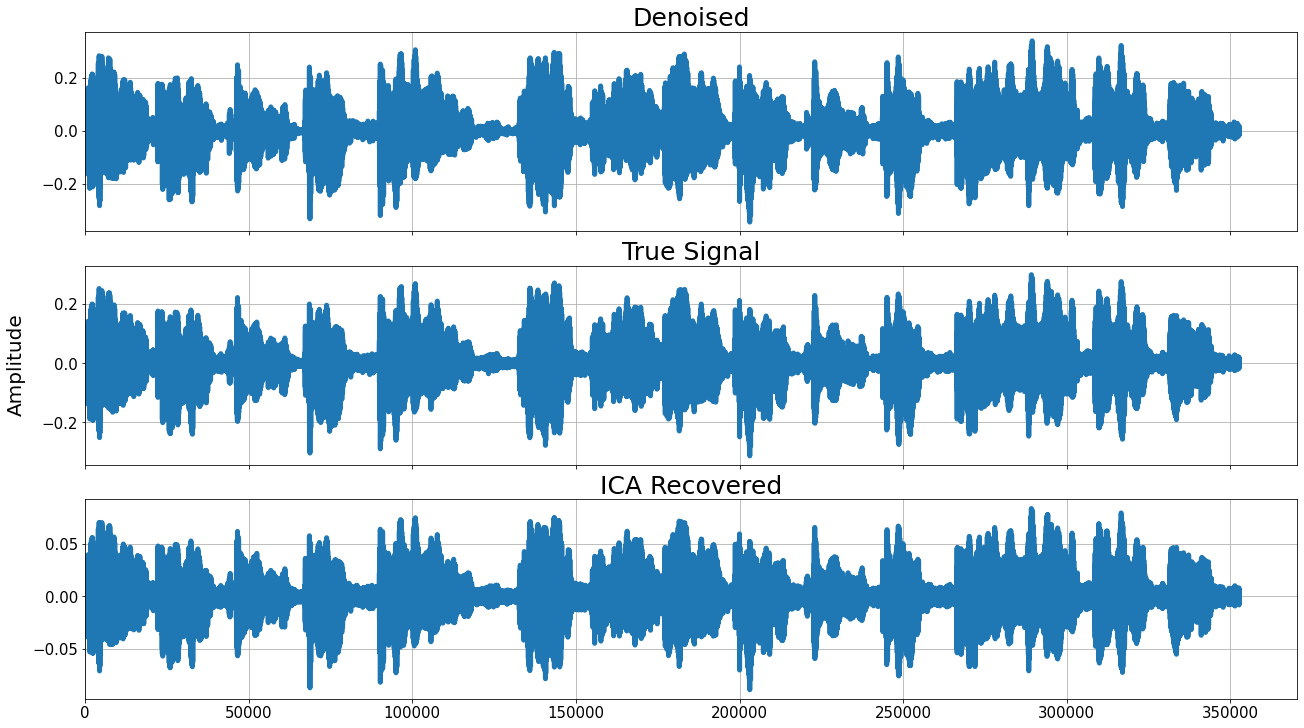

In [51]:
filtered = denoise(ica_recovered[:, 0], wavelet, mode)

fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(filtered * 40, lw=5)
axs[0].set_title('Denoised', fontsize=25)

axs[1].plot(true_signal[:, 1], lw=5)
axs[1].set_title('True Signal', fontsize=25)

axs[2].plot(ica_recovered[:, 0] * 10, lw=5)
axs[2].set_title('ICA Recovered', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Denoised Speech

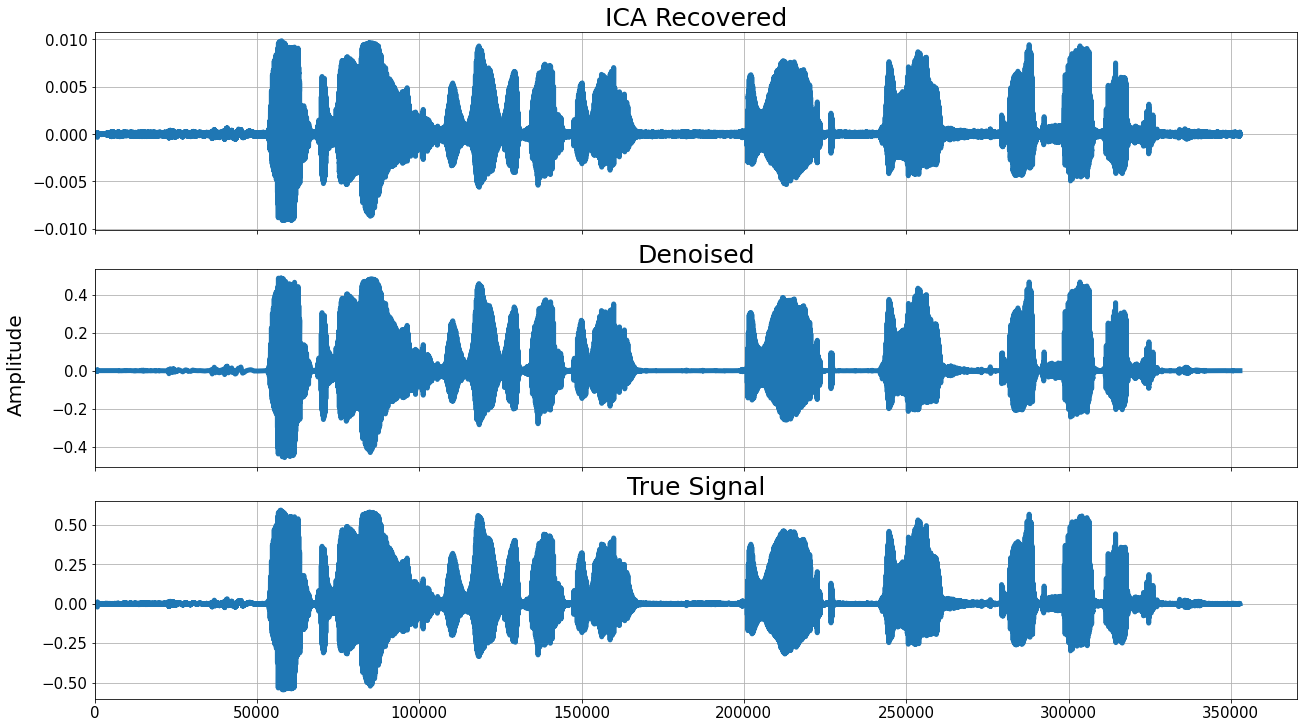

In [52]:
filtered = denoise(ica_recovered[:, 1], wavelet, mode)

fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[1].plot(filtered * 50, lw=5)
axs[1].set_title('Denoised', fontsize=25)

axs[2].plot(true_signal[:, 0], lw=5)
axs[2].set_title('True Signal', fontsize=25)

axs[0].plot(ica_recovered[:, 1], lw=5)
axs[0].set_title('ICA Recovered', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()



# Difference between Recovered Signal and True Signal

In [53]:
filtered_norm = filtered / max(filtered)
true_norm = true_signal[:, 0] / max(true_signal[:, 0])

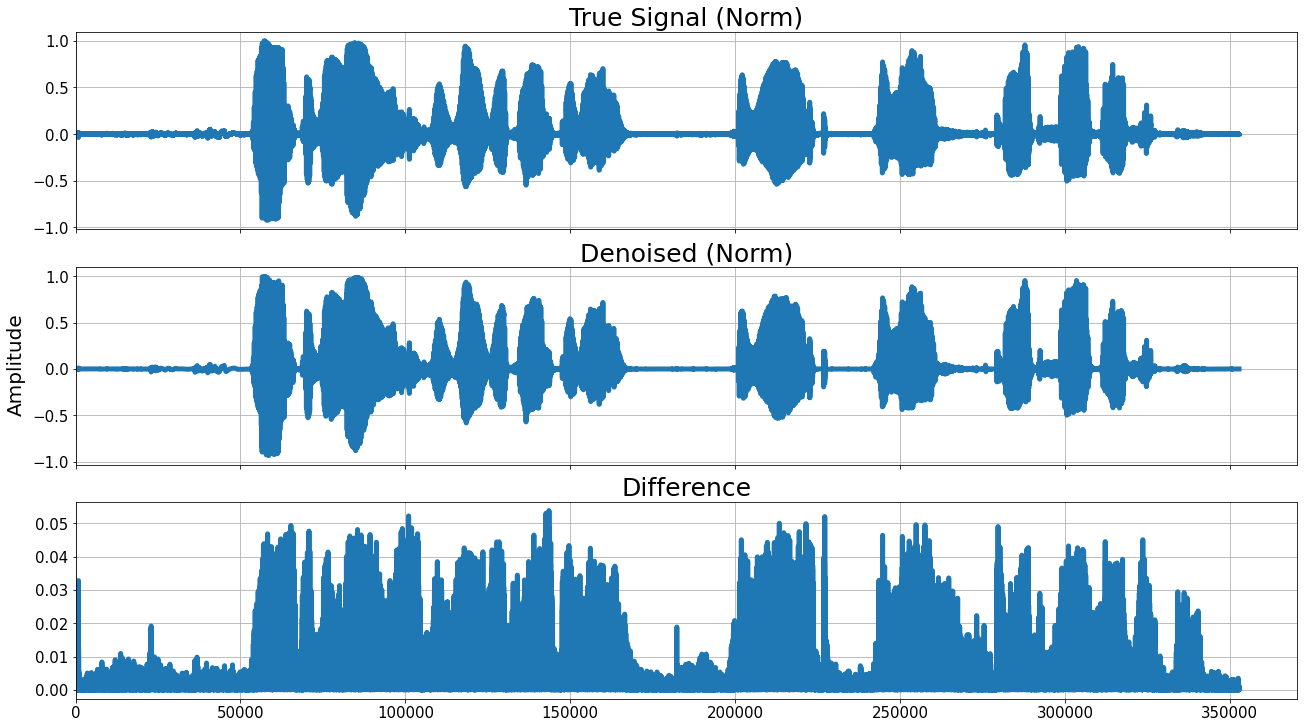

In [55]:
fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[2].plot(abs(abs(true_norm) - abs(filtered_norm)), lw=5)
axs[2].set_title('Difference', fontsize=25)

axs[1].plot(filtered_norm, lw=5)
axs[1].set_title('Denoised (Norm)', fontsize=25)

axs[0].plot(true_norm, lw=5)
axs[0].set_title('True Signal (Norm)', fontsize=25)



for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()


In [56]:
# Save Files
outp_folder = 'recovered'
names_out = ['speech.wav', 'true.wav']
for name, audio, sr in zip(names_out, [filtered_norm, true_norm], [44100, 44100]):
    sf.write(os.path.join(outp_folder, name), audio, sr)